In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def zscore(series):
    return (series - series.mean()) / series.std()

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid(x, k=1, x0=0):
    return 1 / (1 + np.exp(-k * (x - x0)))

def adjusted_sigmoid(x, f_min=0.01, f_max=0.1, k=1, x0=0):
    return f_min + (f_max - f_min) * sigmoid(x, k=k, x0=x0)

def global_sigmoid(x, f_min, f_max, k=1, x0=0):
    if x > 0:
        return adjusted_sigmoid(x, f_min, f_max, k, x0)
    else:
        return adjusted_sigmoid(-x, f_min, f_max, k, x0)


data = pd.read_pickle('data/Merged_CEX_DEX_v2_p1.pkl')
data.head()

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,price_dex,tcost_usd,time,time_dex,price_cex,time_cex,LVR_clean,LVR_clean_cumm,LVR,LVR_cumm
0,18096.796543,-7.930474,18076.269412,0xe743a49f04f2f77eb2d3b753ae3ad599de8cea84,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x4fd39c9e151e50580779bd04b1f7ecc310079fd3,1.704067e+09,427523,1.358341e+10,1.358341e-08,...,2280.878682,13.245562,2024-01-01 00:00:23,2024-01-01 00:00:23,2281.19,2024-01-01 00:00:12.962,0.311318,0.311318,-2.468898,2.468898
1,700.000000,-0.306764,699.212694,0xa1179a0b94e53ee82b77c6d24c2cf67a656c2503,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704067e+09,312000,1.438341e+10,1.438341e-08,...,2280.878682,10.235724,2024-01-01 00:00:23,2024-01-01 00:00:23,2281.19,2024-01-01 00:00:12.962,0.311318,0.622636,-0.095501,2.564399
2,25000.000000,-10.955150,24971.093893,0x9b4306e7b6ede125b5e8cac309ffb58af5eed6f0,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704067e+09,223193,1.259051e+10,1.259051e-08,...,2281.106770,6.410172,2024-01-01 00:00:47,2024-01-01 00:00:47,2282.69,2024-01-01 00:00:35.850,1.583230,2.205866,-17.344522,19.908921
3,767.722283,-0.336412,766.824534,0xc10527cdbc055b7f9a8a4ad765b287190c861c51,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704067e+09,247124,1.230578e+10,1.230578e-08,...,2281.106770,6.936970,2024-01-01 00:00:59,2024-01-01 00:00:59,2282.69,2024-01-01 00:00:35.850,1.583230,3.789096,-0.532617,20.441538
4,170.905965,-0.074890,170.706032,0xf468072ca8f81e11655c252a37317e814b24872b,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0xa9cffe466ba8a72707d1104de239c9ab477e2493,1.704067e+09,2673946,1.443436e+10,1.443436e-08,...,2281.106770,88.043187,2024-01-01 00:01:23,2024-01-01 00:01:23,2281.64,2024-01-01 00:01:08.214,0.533230,4.322326,-0.039934,20.481472


In [76]:
(data[data['LVR_clean']>data['LVR_clean'].quantile(0.9)]['tcost_usd']/data[data['LVR_clean']>data['LVR_clean'].quantile(0.9)]['amountUSD'])

2        0.000257
3        0.009046
13       0.000116
14       0.003482
15       0.007295
           ...   
59959    0.001452
59961    0.005187
59978    0.818687
59979    0.000445
59980    0.312736
Length: 6000, dtype: float64

<Axes: >

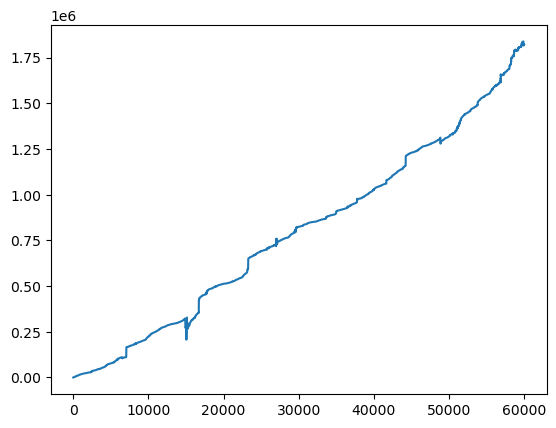

In [77]:
# fees received by LP in USD
# if amount0>0, it is added to the pool and if amount1<0, it is taken from the pool.
fee_receive_quote = data.amount0 + data.amount1 * data.price_dex.shift(1)
fee_receive_quote.cumsum().plot()

<Axes: >

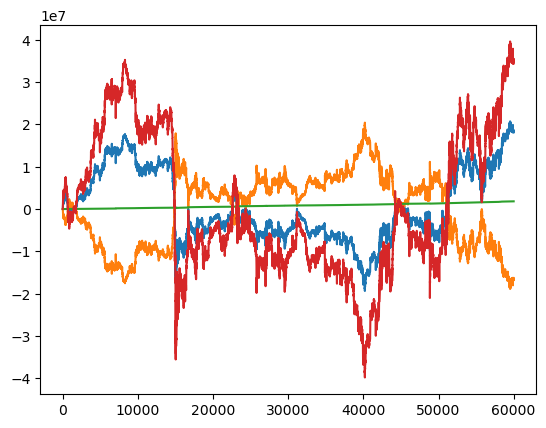

In [78]:
data.amount0.cumsum().plot()
(data.amount1 * data.price_dex.shift(1)).cumsum().plot()
(data.amount0 + data.amount1 * data.price_dex.shift(1)).cumsum().plot()
(data.amount0 - data.amount1 * data.price_dex.shift(1)).cumsum().plot()

<Axes: >

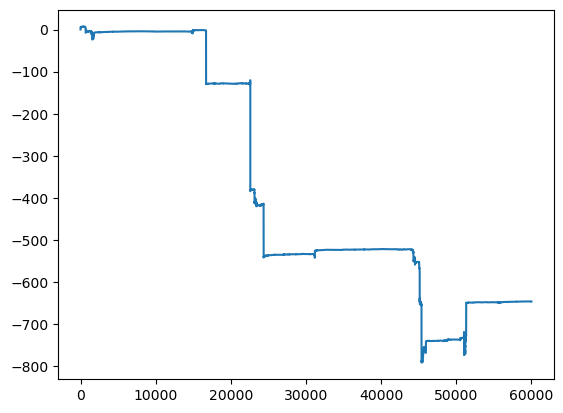

In [79]:
(data.amount0  + data.amount0 ).cumsum().pct_change().cumsum().plot()

<Axes: >

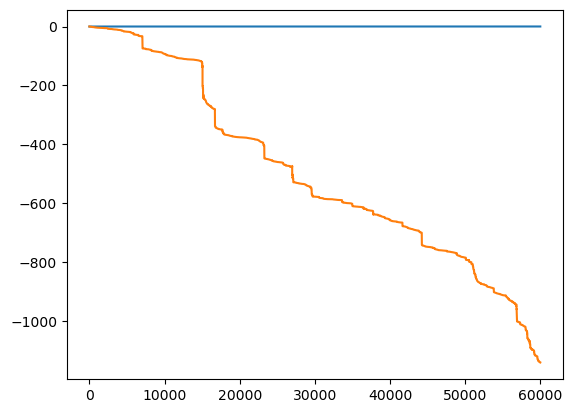

In [80]:
ret_token1 = data.price_dex.pct_change(1)#.shift(1)
ret_pool   = ret_token1 * data.amount1
ret_pool.dropna()

ret_token1.cumsum().plot()
ret_pool.cumsum().plot()

In [81]:
data['time'] = pd.to_datetime(data['time'])
data = data.sort_values('time')

data['LVR_nbtoken']     = data['LVR']/data['price_dex']

data['avg_gas'] = data['gasUsed'] * data['gasPrice_eth'].rolling(100).mean() * data['price_dex']

data['arb_pnl']    = (np.abs(data['LVR_clean'] * data['amountUSD']) - (data['tcost_usd'] - data['avg_gas']))*100 / data['amountUSD']
data['LVR_zscore'] = zscore(data['LVR']) #.clip(-3, 3)


data['std']             = data['price_dex'].rolling(100).std()
data['mean_rol_amount'] = data['amountUSD'].rolling(10).mean()
data['volumeUSD']       = data['amountUSD'].rolling(100).sum()

# can be seen as looking ahead but in a DEX we can compute it aheat with the liquidity and the amount
data['price_impact']    = data['price_dex'].pct_change(1).shift(-1)*100

data['time_diff']           = data['time'].diff().dt.total_seconds().fillna(0)
data['rolling_time_span']   = data['time_diff'].rolling(window=3600, min_periods=1).sum()
data['rolling_trade_count'] = data['time'].rolling(window=3600, min_periods=1).count()
data['lambda'] = data['rolling_trade_count'] / data['rolling_time_span']
data['lambda'].replace([float('inf'), float('-inf'), pd.NA], 0, inplace=True)
data = data.drop(columns=['time_diff']) # , 'rolling_time_span', 'rolling_trade_count'])


data['target_fee'] = -np.tanh(np.sign(data['amount1']) * data['arb_pnl']/100)

data = data.dropna()
data

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,arb_pnl,LVR_zscore,std,mean_rol_amount,volumeUSD,price_impact,rolling_time_span,rolling_trade_count,lambda,target_fee
100,-160.477545,0.070000,160.352835,0xea08db5fb88d6f1f4978400ec2c57d9a29e85e99,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0xef5edb29b4eb20501de89718daa7d1ad108efb66,1.704069e+09,445316,1.225569e+10,1.225569e-08,...,87.938205,-0.009924,4.766625,31043.984573,3.267411e+06,0.000000,1404.0,100.0,0.071225,-0.706110
98,-6808.589388,2.969865,6803.265430,0xf9f12a0370a11ab1cfbb6377040a0e374ae78aa8,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,609606,1.225569e+10,1.225569e-08,...,80.566347,-0.007812,4.713025,31469.253010,3.256138e+06,0.000000,1404.0,101.0,0.071937,-0.667191
101,-99.931075,0.043590,99.853435,0x5e969b786482489323c94b8abc4eb03a41da527a,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0x5e969b786482489323c94b8abc4eb03a41da527a,1.704069e+09,270277,1.144304e+10,1.144304e-08,...,18.581544,-0.009979,4.655251,31203.846347,3.255538e+06,0.010000,1428.0,102.0,0.071429,-0.183706
102,1500.000000,-0.653642,1498.084492,0xfcb40a45a51a31f568ef39e0f6dfe5f3b21711df,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,303561,1.095438e+10,1.095438e-08,...,75.997578,-0.010422,4.599576,20749.062023,3.232065e+06,0.000000,1476.0,103.0,0.069783,0.641063
103,-550.210323,0.240000,549.781949,0xcdb343941111e306d71f141689b5b69d07ca6f59,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,306333,1.182152e+10,1.182152e-08,...,76.959780,-0.009811,4.539570,20425.349686,3.231848e+06,0.000000,1500.0,104.0,0.069333,-0.646696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59994,-3609.600145,1.400000,3614.875537,0x09377b785178a3dfe548328123604668b51105a0,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704932e+09,256486,5.365090e+10,5.365090e-08,...,263.589823,-0.013316,7.560117,38569.517075,6.724532e+06,0.000000,32388.0,3600.0,0.111152,-0.989784
59995,-2062.694719,0.800000,2065.676196,0xca74f404e0c7bfa35b13b511097df966d5a65597,0x1111111254eeb25477b68fb85ed929f73a960582,0x1111111254eeb25477b68fb85ed929f73a960582,1.704932e+09,403756,5.626490e+10,5.626490e-08,...,264.090129,-0.011884,7.507411,38686.836319,6.724595e+06,0.000000,32388.0,3600.0,0.111152,-0.989885
59996,-3953.442238,1.533426,3959.304818,0x475d2c6f6a46a83d1781e61500d1c540f85fd721,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0x475d2c6f6a46a83d1781e61500d1c540f85fd721,1.704932e+09,248525,5.216118e+10,5.216118e-08,...,242.561274,-0.013343,7.453936,38555.229368,6.662888e+06,-0.019997,32388.0,3600.0,0.111152,-0.984484
59997,-9584.192801,3.717716,9598.772684,0xeef68d213fbbf6f01235a6c1318f82a1692c01de,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0xeef68d213fbbf6f01235a6c1318f82a1692c01de,1.704932e+09,341150,4.985426e+10,4.985426e-08,...,121.849365,-0.014075,7.403159,38889.495677,6.668813e+06,0.060015,32400.0,3600.0,0.111111,-0.839209


In [138]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# you cannot include the tcost_usd as it is the target variable and it would be a lookahead bias as we wont be able to know it in real time when trader whants a quote
features = ['LVR_nbtoken', 'LVR_zscore', 'std', 'mean_rol_amount', 'avg_gas', # 'rolling_trade_count', 'price_impact',
            'volumeUSD', 'lambda',  'rolling_time_span', 'amountUSD']
target = 'target_fee'

lower_bound = data[features].quantile(0.10)
upper_bound = data[features].quantile(0.90)

# Filter out outliers
filtered_indices = data[features].apply(lambda x: x.between(lower_bound[x.name], upper_bound[x.name])).all(axis=1)
data_filtered = data.loc[filtered_indices].copy()

# Apply Z-Score Normalization
scaler = StandardScaler()
data_filtered[features] = scaler.fit_transform(data_filtered[features])

X_filtered = data_filtered[features]
y_filtered = data_filtered[target]

X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

y_pred_train_normalized = y_pred_train # (y_pred_train / np.std(y_pred_train)).clip(-1, 1)
y_pred_test_normalized = y_pred_test # (y_pred_test / np.std(y_pred_test)).clip(-1, 1)

mse_test = mean_squared_error(y_test, y_pred_test_normalized)
print(f"Mean Squared Error (Test): {mse_test.round(3)}")

X_test['target'] = y_test
X_test['target_preticted'] = y_pred_test_normalized

data_filtered.loc[X_train.index, 'target_preticted'] = y_pred_train_normalized
data_filtered.loc[X_test.index, 'target_preticted'] = y_pred_test_normalized

coefficients = dict(zip(features, model.coef_))
print("\nCoefficients and Variables:")
for feature, coef in coefficients.items():
    print(f"{feature}: {round(coef, 4)}")

Mean Squared Error (Test): 0.371

Coefficients and Variables:
LVR_nbtoken: 1.1379
LVR_zscore: -1.0936
std: -0.0119
mean_rol_amount: 0.0185
avg_gas: -0.0138
volumeUSD: 0.0188
lambda: -0.1271
rolling_time_span: -0.1411
amountUSD: 0.0378


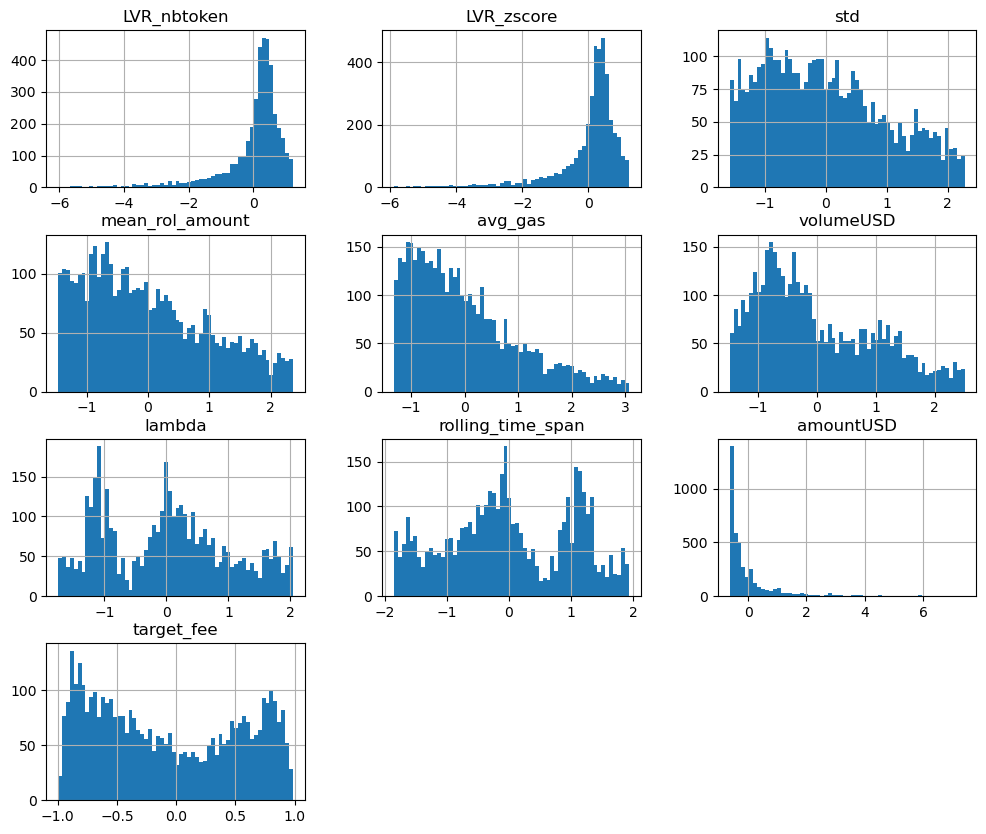

In [139]:
data_filtered[features+[target]].hist(bins=60, figsize=(12, 10))
plt.show()

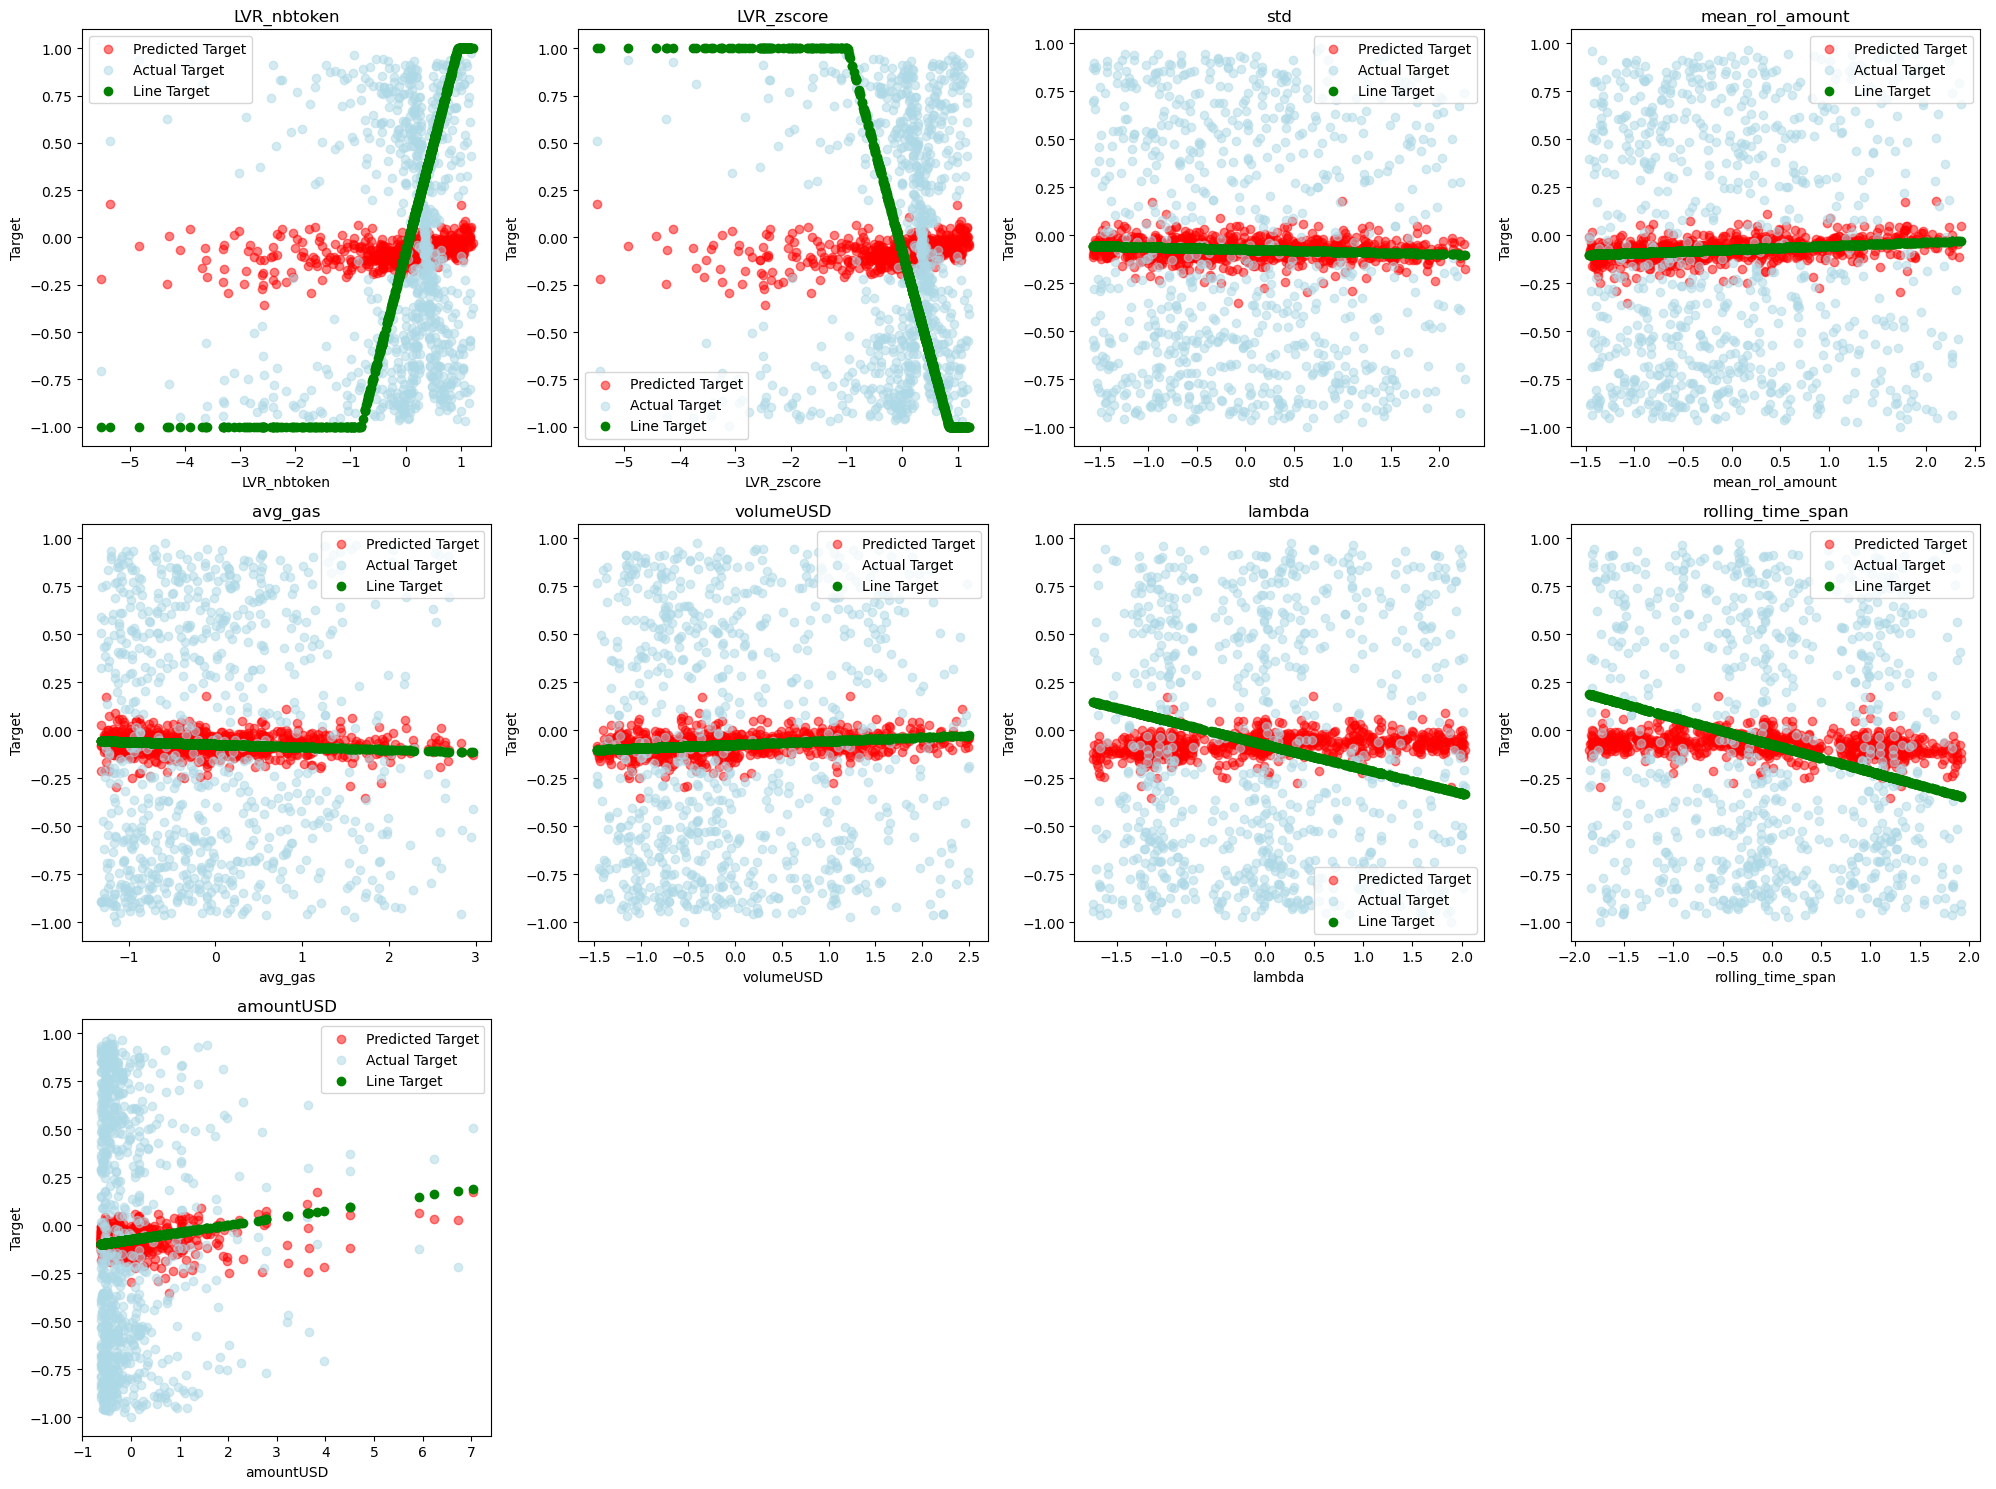

In [140]:
plots_per_row = 4

total_features = len(features)

num_rows = total_features // plots_per_row + (1 if total_features % plots_per_row else 0)

fig, axs = plt.subplots(num_rows, plots_per_row, figsize=(plots_per_row * 5, num_rows * 5))

axs = axs.flatten()

for i, feature_to_plot in enumerate(features):
    y = (coefficients[feature_to_plot] * X_test[feature_to_plot] + model.intercept_).clip(-1,1)
    
    axs[i].scatter(X_test[feature_to_plot], y_pred_test_normalized, color='red',       label='Predicted Target', alpha=0.5)
    axs[i].scatter(X_test[feature_to_plot], y_test,                 color='lightblue', label='Actual Target', alpha=0.5)
    axs[i].scatter(X_test[feature_to_plot], y,                      color='green',     label='Line Target')
    
    axs[i].set_xlabel(feature_to_plot)
    axs[i].set_ylabel('Target')
    axs[i].set_title(f'{feature_to_plot}')
    axs[i].legend()

for ax in axs[len(features):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


/var/folders/fn/zk93lv7x5qb0fyk32l1610240000gn/T/ipykernel_26941/2624362680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_subset['model_fee'] = buy_subset['LVR_zscore'].apply(lambda x: adjusted_sigmoid(x, f_min, f_max, k, x0))
/var/folders/fn/zk93lv7x5qb0fyk32l1610240000gn/T/ipykernel_26941/2624362680.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sell_subset['model_fee'] = -sell_subset['LVR_zscore'].apply(lambda x: adjusted_sigmoid(-x, f_min, f_max, k, x0))


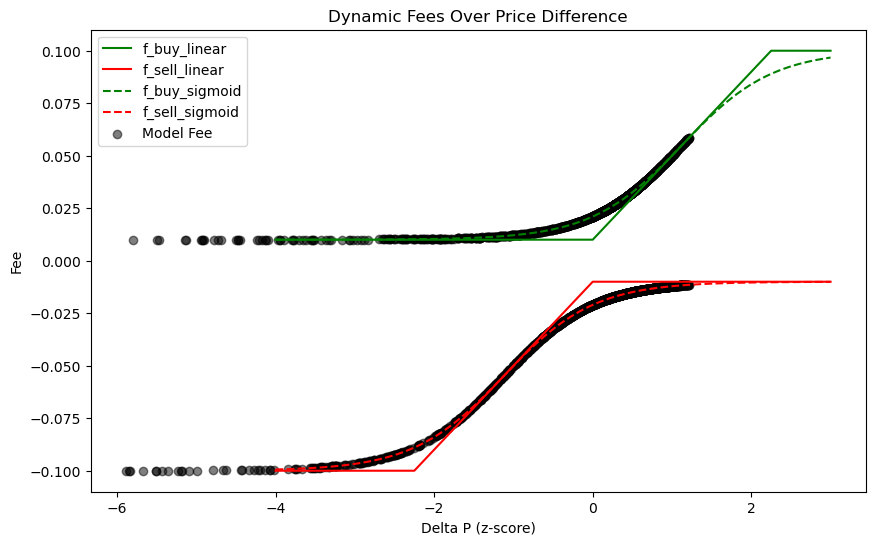

In [176]:
delta_p = pd.DataFrame({'delta_p': np.linspace(-4, 3, 2001)})
f_min = 0.01
f_max = 0.1
w     = 0.04

delta_p['f_buy_linear']  = delta_p['delta_p'].apply(lambda x: min(f_max, f_min + w * max(0, x)))
delta_p['f_sell_linear'] = delta_p['delta_p'].apply(lambda x: min(f_max, f_min - w * min(0, x)))

x0 = (f_max-f_min)/(2*w)  # Adjust x0 as needed based on your understanding of the data
k = 1.75  # Steepness of the curve

delta_p['f_buy_sigmoid'] = delta_p['delta_p'].apply(lambda x: adjusted_sigmoid(x, f_min, f_max, k, x0))
delta_p['f_sell_sigmoid'] = delta_p['delta_p'].apply(lambda x: adjusted_sigmoid(-x, f_min, f_max, k, x0))

plt.figure(figsize=(10, 6))

plt.plot(delta_p['delta_p'], delta_p['f_buy_linear'],  label='f_buy_linear', color='green')
plt.plot(delta_p['delta_p'], -delta_p['f_sell_linear'], label='f_sell_linear', color='red')

plt.plot(delta_p['delta_p'], delta_p['f_buy_sigmoid'],  label='f_buy_sigmoid',  linestyle='--', color='green')
plt.plot(delta_p['delta_p'], -delta_p['f_sell_sigmoid'], label='f_sell_sigmoid', linestyle='--', color='red')

# Segment the data based on 'amount1'
buy_subset = data_filtered[data_filtered['amount1'] < 0]
sell_subset = data_filtered[data_filtered['amount1'] > 0]

# Apply the fees
buy_subset['model_fee'] = buy_subset['LVR_zscore'].apply(lambda x: adjusted_sigmoid(x, f_min, f_max, k, x0))
sell_subset['model_fee'] = -sell_subset['LVR_zscore'].apply(lambda x: adjusted_sigmoid(-x, f_min, f_max, k, x0))

# Combine the subsets for plotting
combined_data = pd.concat([buy_subset, sell_subset])
plt.scatter(combined_data['LVR_zscore'], combined_data['model_fee'], alpha=0.5, color='black', label='Model Fee')

plt.xlabel('Delta P (z-score)')
plt.ylabel('Fee')
plt.legend()
plt.title('Dynamic Fees Over Price Difference')
plt.show()


/var/folders/fn/zk93lv7x5qb0fyk32l1610240000gn/T/ipykernel_26941/4238391645.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_subset['model_fee'] = buy_subset['LVR_zscore'].apply(lambda x: adjusted_sigmoid(x, f_min, f_max, k, x0))
/var/folders/fn/zk93lv7x5qb0fyk32l1610240000gn/T/ipykernel_26941/4238391645.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sell_subset['model_fee'] = -sell_subset['LVR_zscore'].apply(lambda x: adjusted_sigmoid(-x, f_min, f_max, k, x0))


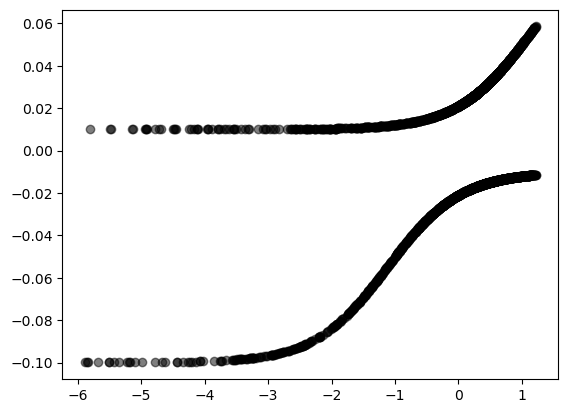

In [175]:
# Assuming data_filtered is your DataFrame and it includes 'amount1' and 'LVR_zscore' columns

# Segment the data based on 'amount1'
buy_subset = data_filtered[data_filtered['amount1'] < 0]
sell_subset = data_filtered[data_filtered['amount1'] > 0]

# Apply the fees
buy_subset['model_fee'] = buy_subset['LVR_zscore'].apply(lambda x: adjusted_sigmoid(x, f_min, f_max, k, x0))
sell_subset['model_fee'] = -sell_subset['LVR_zscore'].apply(lambda x: adjusted_sigmoid(-x, f_min, f_max, k, x0))

# Combine the subsets for plotting
combined_data = pd.concat([buy_subset, sell_subset])
plt.scatter(combined_data['LVR_zscore'], combined_data['model_fee'], alpha=0.5, color='black', label='Model Fee')


In [ ]:
delta_p = pd.DataFrame({'delta_p': np.linspace(-4, 3, 2001)})
f_min = 0.01
f_max = 0.1
w     = 0.04

def global_sigmoid(x, f_min, f_max, k=1, x0=0):
    if x > 0:
        return adjusted_sigmoid(x, f_min, f_max, k, x0)
    else:
        return adjusted_sigmoid(-x, f_min, f_max, k, x0)

delta_p['f_buy_linear']  = delta_p['delta_p'].apply(lambda x: min(f_max, f_min + w * max(0, x)))
delta_p['f_sell_linear'] = delta_p['delta_p'].apply(lambda x: min(f_max, f_min - w * min(0, x)))

x0 = (f_max-f_min)/(2*w)  # Adjust x0 as needed based on your understanding of the data
k = 1.75  # Steepness of the curve

delta_p['f_buy_sigmoid'] = delta_p['delta_p'].apply(lambda x: adjusted_sigmoid(x, f_min, f_max, k, x0))
delta_p['f_sell_sigmoid'] = delta_p['delta_p'].apply(lambda x: adjusted_sigmoid(-x, f_min, f_max, k, x0))

plt.figure(figsize=(10, 6))

plt.plot(delta_p['delta_p'], delta_p['f_buy_linear'],  label='f_buy_linear', color='green')
plt.plot(delta_p['delta_p'], delta_p['f_sell_linear'], label='f_sell_linear', color='red')

plt.plot(delta_p['delta_p'], delta_p['f_buy_sigmoid'],  label='f_buy_sigmoid',  linestyle='--', color='green')
plt.plot(delta_p['delta_p'], delta_p['f_sell_sigmoid'], label='f_sell_sigmoid', linestyle='--', color='red')

data_filtered['model_fee'] = data_filtered['LVR_zscore'].apply(lambda x: global_sigmoid(x, f_min, f_max, k, x0))
plt.scatter(data_filtered['LVR_zscore'], data_filtered['model_fee'], alpha=0.5, color='black', label='Model Fee')

plt.xlabel('Delta P (z-score)')
plt.ylabel('Fee')
plt.legend()
plt.title('Dynamic Fees Over Price Difference')
plt.show()


In [156]:
# buy tx
data_filtered['amount0']>0

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,volumeUSD,price_impact,rolling_time_span,rolling_trade_count,lambda,target_fee,prediction_train,prediction_test,target_preticted,model_fee
5045,-671.517498,0.288000,-0.583714,0x1553db1d5b5ee3ac04dfc8b5858b6cd8ecc1b7a5,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704149e+09,408210,1.372893e+10,1.372893e-08,...,-1.355433,0.000000,1.918215,3600.0,-1.737407,-0.793886,-1.00000,NaN,-0.165228,0.024613
5159,-830.804443,0.355125,-0.556180,0x447bcac1152d8fe5fc2ce4acfd0d87d89b84db6b,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x447bcac1152d8fe5fc2ce4acfd0d87d89b84db6b,1.704150e+09,319768,1.705612e+10,1.705612e-08,...,-1.208190,0.000000,1.596218,3600.0,-1.486323,-0.841906,-1.00000,NaN,-0.082521,0.035709
5165,1279.091995,-0.546135,-0.478412,0x6269bc7832f51f2e78b2b3048d965a2f94eb0eb0,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704150e+09,359920,1.533312e+10,1.533312e-08,...,-1.080885,0.000000,1.572492,3600.0,-1.467412,0.886956,-1.00000,NaN,-0.080702,0.042019
5166,-9096.701192,3.887838,0.879939,0x16c473448e770ff647c69cbe19e28528877fba1b,0xe592427a0aece92de3edee1f18e0157c05861564,0x9008d19f58aabd9ed0d60971565aa8510560ab41,1.704150e+09,977992,1.676643e+10,1.676643e-08,...,-1.072986,0.000000,1.572492,3600.0,-1.467412,-0.886706,-1.00000,NaN,-0.154882,0.010115
5169,-3255.974225,1.391600,-0.134831,0x9214e68a10cbc19a9b3b1170f917cd40489823cf,0x03f911aedc25c770e701b8f563e8102cfacd62c0,0x11181bd3baf5ce2a478e98361985d42625de35d1,1.704150e+09,414967,1.933834e+10,1.933834e-08,...,-1.073242,0.000000,1.562324,3600.0,-1.459289,-0.886523,-1.00000,NaN,-0.160135,0.013379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57524,7000.000000,-2.882700,0.516631,0x3b69efcbecb6be7e9857c0bf5ecce892367b5549,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704913e+09,270173,4.504837e+10,4.504837e-08,...,0.881285,0.000000,-0.918741,3600.0,0.899799,0.926670,-1.00000,NaN,-0.026009,0.010241
57531,-1341.420197,0.552687,-0.467230,0x3bae26c9ee93467619ebb3d0dbc3d052243cacb4,0x8793c6aa63cc96c955da4906f628dc09cd595dc8,0xfcedca7ad9ea9e9cbf580eabb479a000ac45b291,1.704913e+09,345217,4.107489e+10,4.107489e-08,...,0.940947,-0.009999,-0.918741,3600.0,0.899799,-0.454534,NaN,-1.0,-0.107093,0.032763
57545,8170.727169,-3.356722,0.718488,0xea4a30458f9a96d9a88369d9574ccb61ef1059af,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704913e+09,319606,4.392203e+10,4.392203e-08,...,1.034659,0.010000,-0.939078,3600.0,0.922837,0.692620,-1.00000,NaN,0.012739,0.011440
57546,3771.290702,-1.549221,-0.045593,0xcd57b2cdc5acabb8cd3ab08a40e4eedaaf3ee762,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704913e+09,311987,4.281971e+10,4.281971e-08,...,1.038064,-0.009999,-0.939078,3600.0,0.922837,0.782614,-0.90804,NaN,-0.039659,0.014608


In [142]:
data_filtered['LVR_zscore']

5045     0.187466
5159     0.601238
5165     0.785696
5166    -2.679625
5169    -0.728718
           ...   
57524   -2.257721
57531    0.506089
57545   -1.228850
57546   -0.543270
57609    0.393943
Name: LVR_zscore, Length: 4053, dtype: float64

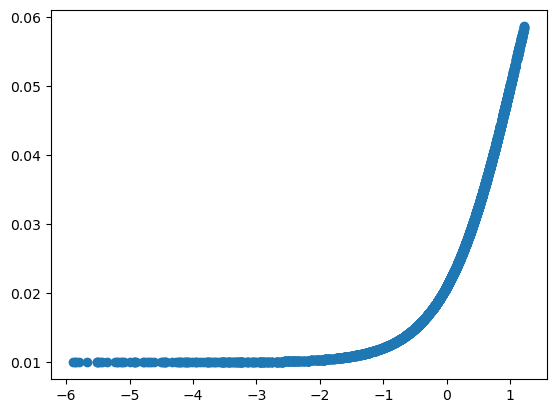

In [141]:
data_filtered['f_buy']  = adjusted_sigmoid(data_filtered['LVR_zscore'], f_min, f_max, k=1.75, x0=(f_max-f_min)/(2*w))

,LVR_nbtoken,LVR_zscore,std,mean_rol_amount,avg_gas,volumeUSD,lambda,rolling_time_span,amountUSD,target,target_preticted
12946,0.642617,0.650338,0.523170,-0.901211,-1.087956,-0.684288,0.314353,-0.379821,-0.505183,0.803672,-0.080850
12128,0.379356,0.379538,-1.338747,0.438983,-1.219581,-0.739544,0.265014,-0.332369,-0.620059,-0.191745,-0.041318
22158,0.331213,0.331696,-1.193603,-1.182474,-1.034926,-1.335198,-0.986853,0.992899,-0.530316,0.111862,-0.113771
26056,0.731782,0.720730,0.464047,-1.023709,1.944968,-0.614472,1.863425,-1.718648,0.870453,-0.161675,-0.054505
14405,0.904417,0.922085,-0.930272,1.083072,-0.449388,-1.152806,-1.701045,1.870763,-0.361983,0.845612,-0.099806
...,...,...,...,...,...,...,...,...,...,...,...
43247,0.543827,0.540540,0.192944,-1.165231,0.146460,1.353367,-0.017231,-0.054436,-0.109406,-0.217529,-0.041715
49988,0.555626,0.551281,-0.854953,-0.511739,0.980238,-0.138180,-1.690616,1.857205,1.023526,0.079293,-0.069331
14029,-0.692936,-0.720785,0.211679,-1.111600,0.074467,0.308538,-1.125455,1.155592,0.577159,0.556169,-0.091541
27849,0.679315,0.671708,0.095148,-0.235076,-1.196699,-0.091408,-0.773220,0.748860,-0.545225,0.891373,-0.054965


In [ ]:
# 'origin','sender'
data[['LVR_pnl_percent', 'origin']].groupby('origin').sum()

,LVR_pnl_percent
origin,
0x0000000000211b7cdd33049a9f1985013babb784,227.933460
0x000000000026a1f577dbf53aaf2c82be36dad52e,158.115101
0x00000000006753b3acb0d6f57a11abce4cffc049,167.642743
0x000000000092214e86d0c37795c80807d0ab14dc,188.280430
0x0000000000b3b15e53730ee3042f8b12fc659535,8.786646
...,...
0xffeccfec9c710f3d51876d0c4a0e7920fd4856d8,156.178062
0xfff2c305b277879cc2e9c273632e9523ed99cdde,219.482007
0xfffa84476428be3370be2802b6e0fad24d9fe833,74.419108


In [ ]:
tmp = (data[['LVR_pnl_percent', 'sender']].groupby('sender').sum()>100).reset_index()
abritrageur_address_list = tmp[tmp['LVR_pnl_percent'] == True].sender.values
print(len(abritrageur_address_list))
filtered_data = data[data['sender'].isin(abritrageur_address_list)]
t = data[['LVR_pnl_percent', 'sender']].groupby('sender').sum().apply(lambda x : sigmoid(x))

201


/Users/armandmorin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# methodology:
# Take a rolling windows of the past 1 million tx for instance
# Perform all the signle trades analysis, in term of pnl anf LVR percent
# Aggregate the metrics to get the trader perfs 
# Charge the fee per trader

def fee_pnl(LVR_pnl_percent):
    # output is in 100%
    coef = 1
    return sigmoid(LVR_pnl_percent / 250) * coef

def fee_base(LVR_zscore):
    # output is in 100%
    base_pool_fee = 0.05
    coef = 1.03
    return coef * sigmoid(base_pool_fee + LVR_zscore * 0.03)

agg_sender = data[['LVR_pnl_percent', 'LVR_zscore', 'sender']].groupby('sender').sum()
agg_origin = data[['LVR_pnl_percent', 'LVR_zscore', 'origin']].groupby('origin').sum()
agg_recipient = data[['LVR_pnl_percent', 'LVR_zscore', 'recipient']].groupby('recipient').sum()

dico_percent = {}
dico_zscore = {}

for df in [agg_sender, agg_origin, agg_recipient]:
    for address, lvr_percent, lvr_zscore in zip(df.index, df['LVR_pnl_percent'], df['LVR_zscore']):
        if address in dico_percent:
            dico_percent[address] += lvr_percent
            dico_zscore[address] += lvr_zscore
        else:
            dico_percent[address] = lvr_percent
            dico_zscore[address] = lvr_zscore


# filter addresses trading with positive LVR return 
dic_base_fee = {address: fee_base(LVR_zscore) for address, LVR_zscore in dico_zscore.items() if LVR_zscore > 0}

dic_fee       = {address: fee_pnl(LVR_pnl_percent) for address, LVR_pnl_percent in dico_percent.items() if LVR_pnl_percent > 0 }

merged_dict = {key: dic_fee.get(key, 0) + dic_base_fee.get(key, 0) for key in set(dic_fee) | set(dic_base_fee)}

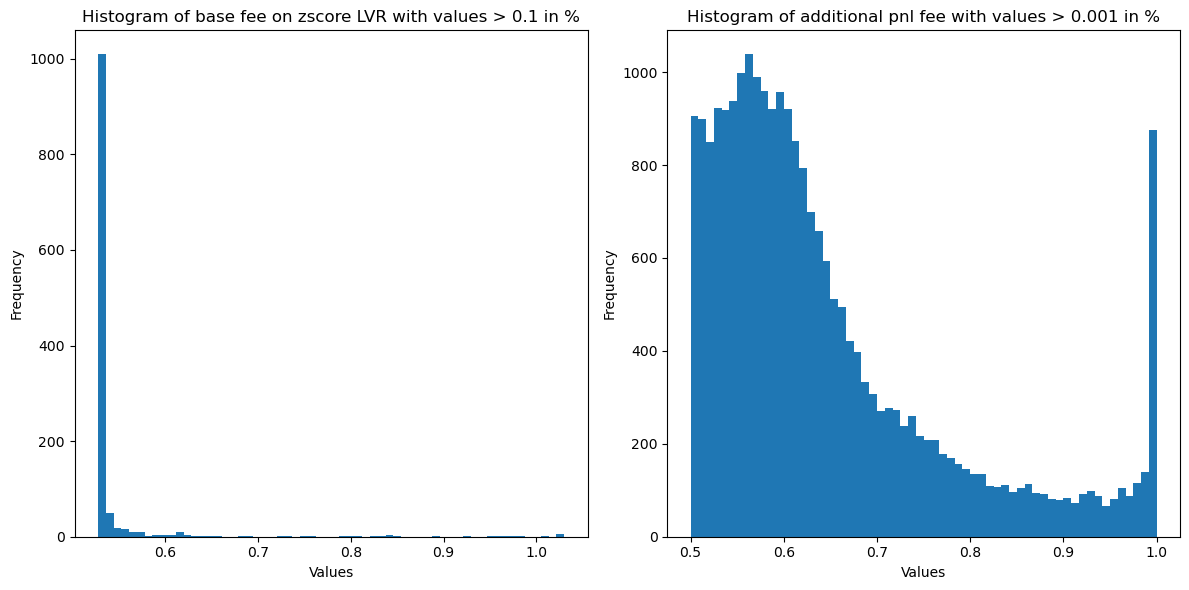

In [ ]:
import matplotlib.pyplot as plt

# Filter values greater than threshold in %
threshold_base = 0.1
threshold_fees = 0.001
filtered_base_values = [value for value in dic_base_fee.values() if value > threshold_base]
filtered_fee_values = [value for value in dic_fee.values() if value > threshold_fees]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.hist(filtered_base_values, bins=60)
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')
ax1.set_title(f'Histogram of base fee on zscore LVR with values > {threshold_base} in %')

ax2.hist(filtered_fee_values, bins=60)
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')
ax2.set_title(f'Histogram of additional pnl fee with values > {threshold_fees} in %')

plt.tight_layout()
plt.show()


In [ ]:
please = pd.DataFrame.from_dict(merged_dict, orient='index', columns=['fees'])
please = please.reset_index().rename(columns={'index': 'address'}).sort_values(by='fees', ascending=False)

merged_data = data.merge(please.rename(columns={'fees' : 'f1'}), left_on='sender', how='left', right_on='address')
merged_data = merged_data.merge(please.rename(columns={'fees' : 'f2'}), left_on='origin', how='left', right_on='address')
merged_data = merged_data.merge(please.rename(columns={'fees' : 'f3'}), left_on='recipient', how='left', right_on='address')

merged_data[['f1', 'f2', 'f3']] = merged_data[['f1', 'f2', 'f3']].fillna(0).clip(lower=0.05)

merged_data['mean_fee'] = merged_data[['f1', 'f2', 'f3']].mean(axis=1) 
#merged_data['max_fee']  = merged_data[['f1', 'f2', 'f3']].max(axis=1) 

merged_data = merged_data.drop(columns=['address_x', 'address_y', 'address', 'f1', 'f2', 'f3']).fillna(0.5)

merged_data

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,LVR_nbtoken,LVR_pnl_percent,LVR_zscore,std,mean_rol_amount,volumeUSD,price_impact,lambda,target_fee,mean_fee
0,18096.796543,-7.930474,18076.269412,0xe743a49f04f2f77eb2d3b753ae3ad599de8cea84,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x4fd39c9e151e50580779bd04b1f7ecc310079fd3,1.704067e+09,427523,1.358341e+10,1.358341e-08,...,-0.001082,31.058511,-0.012213,0.500000,0.500000,5.000000e-01,0.000000,0.000000,0.499817,0.366667
1,700.000000,-0.306764,699.212694,0xa1179a0b94e53ee82b77c6d24c2cf67a656c2503,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704067e+09,312000,1.438341e+10,1.438341e-08,...,-0.000042,29.667895,-0.010061,0.500000,0.500000,5.000000e-01,0.000100,0.000000,0.496340,0.209878
2,25000.000000,-10.955150,24971.093893,0x9b4306e7b6ede125b5e8cac309ffb58af5eed6f0,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704067e+09,223193,1.259051e+10,1.259051e-08,...,-0.007604,158.297330,-0.025702,0.500000,0.500000,5.000000e-01,0.000000,0.125000,0.499936,1.175693
3,767.722283,-0.336412,766.824534,0xc10527cdbc055b7f9a8a4ad765b287190c861c51,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704067e+09,247124,1.230578e+10,1.230578e-08,...,-0.000233,157.418365,-0.010458,0.500000,0.500000,5.000000e-01,0.000000,0.111111,0.497738,0.906057
4,170.905965,-0.074890,170.706032,0xf468072ca8f81e11655c252a37317e814b24872b,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0xa9cffe466ba8a72707d1104de239c9ab477e2493,1.704067e+09,2673946,1.443436e+10,1.443436e-08,...,-0.000018,1.747092,-0.010011,0.500000,0.500000,5.000000e-01,0.000100,0.083333,0.373844,0.050000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,-2062.694719,0.800000,2065.676196,0xca74f404e0c7bfa35b13b511097df966d5a65597,0x1111111254eeb25477b68fb85ed929f73a960582,0x1111111254eeb25477b68fb85ed929f73a960582,1.704932e+09,403756,5.626490e+10,5.626490e-08,...,-0.000816,260.387510,-0.011884,7.507411,38686.836319,6.724595e+06,0.000000,0.111152,0.507092,1.000000
59996,-3953.442238,1.533426,3959.304818,0x475d2c6f6a46a83d1781e61500d1c540f85fd721,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0x475d2c6f6a46a83d1781e61500d1c540f85fd721,1.704932e+09,248525,5.216118e+10,5.216118e-08,...,-0.001440,241.379868,-0.013343,7.453936,38555.229368,6.662888e+06,-0.000200,0.111152,0.502112,0.915576
59997,-9584.192801,3.717716,9598.772684,0xeef68d213fbbf6f01235a6c1318f82a1692c01de,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0xeef68d213fbbf6f01235a6c1318f82a1692c01de,1.704932e+09,341150,4.985426e+10,4.985426e-08,...,-0.001753,121.182189,-0.014075,7.403159,38889.495677,6.668813e+06,0.000600,0.111111,0.501142,0.598821
59998,50010.837140,-19.375430,50056.125466,0xe4e968b3abe7123f18b318e8ad17ce3826b5cff6,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704932e+09,332676,4.989490e+10,4.989490e-08,...,0.033442,445.340477,0.068279,7.393779,43395.056279,6.686023e+06,-0.001299,0.111029,0.499786,0.494755


In [ ]:
(merged_data['mean_fee'] * merged_data['amountUSD']/100).sum()

29646230.103912454

In [ ]:
merged_data['LVR'].sum()

660046.1473910192